In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#Carga de datos
url = "https://drive.google.com/file/d/1VEuZd7Hel7wezBAfdxZYGgjeaLRA4YwP/view?usp=sharing"
url ='https://drive.google.com/uc?id=' + url.split('/')[-2]

# Cargar el archivo CSV en un DataFrame de pandas
data = pd.read_csv(url)
data.head(2)

,Aircraft Type,Users Reviews,Country,Type_of_Travellers,Route,Seat_Types,Seat Comfort,Date Flown,Cabin Staff Service,Ground Service,Food & Beverages,Wifi & Connectivity,Inflight Entertainment,Value For Money,Recommended
0,NaN,✅Trip Verified| Cancelled our flight last-min...,United Kingdom,Couple Leisure,London Heathrow to Tokyo,Economy Class,1.0,Sep-23,1.0,2.0,1.0,NaN,3.0,1,no
1,NaN,"✅Trip Verified| I had a flight from Miami, Flo...",United States,Solo Leisure,Miami to Dublin via London Heathrow,Business Class,1.0,Aug-23,3.0,1.0,2.0,1.0,1.0,1,no


# Limpieza Data

## Transformación de fechas

In [ ]:
# Agrega el año 2024 y convierte a formato de fecha
data['Date Flown'] = pd.to_datetime(data['Date Flown'] + '-2024', format='%b-%d-%Y')

# Crea la serie de tiempo
serie_tiempo = pd.Series(data.index, index=data['Date Flown'])
serie_tiempo_por_mes = serie_tiempo.resample('M').count()

## Manejo de duplicados

In [ ]:
data.duplicated().sum()

63

In [ ]:
data = data.drop_duplicates()
data.duplicated().sum()

0

# Graficos

## Coroplético

In [ ]:
# Dividir la columna 'Route' en dos partes: origen y destino
split_routes = data['Route'].str.split(' to ', n=1, expand=True)
data['Origin'] = split_routes[0].str.strip().replace('London Heathrow', 'London')
data['Destination'] = split_routes[1]
split_routes = data['Destination'].str.split(' via ', n=1, expand=True)
data['Destination'] = split_routes[0].str.strip().replace('London Heathrow', 'London')
data['Destination'] = data['Destination'].str.strip().replace('LHR', 'London')
data['Destination'] = data['Destination'].str.strip().replace('Gatwick', 'London')
data['Destination'] = data['Destination'].str.strip().replace('Heathrow', 'London')
data['Destination'] = data['Destination'].str.strip().replace('LGW', 'London')
data['Destination'] = data['Destination'].str.strip().replace('London City', 'London')
data['Destination'] = data['Destination'].str.strip().replace('London Gatwick', 'London')
data['Destination'] = data['Destination'].str.strip().replace('JFK', 'New York')


# Contar la frecuencia de los países
country_counts = data['Destination'].value_counts()

# Obtener el top de países más comunes
df = country_counts.head(20).to_frame()
df = df.reset_index()

In [ ]:
# Asignar los países a las ciudades (usando solo una para demostración)
city_to_country = {
    'London': 'United Kingdom',
    'New York': 'United States',
    'Cape Town': 'South Africa',
    'Johannesburg': 'South Africa',
    'Los Angeles': 'United States',
    'Vancouver': 'Canada',
    'Paris': 'France',
    'Dubai': 'United Arab Emirates',
    'Edinburgh': 'United Kingdom',
    'Madrid': 'Spain',
    'Las Vegas': 'United States',
    'Malaga': 'Spain',
    'Hong Kong': 'China',
    'Rome': 'Italy',
    'Singapore': 'Singapore',
    'Amsterdam': 'Netherlands',
    'Bangkok': 'Thailand',
    'Boston': 'United States',
    'Toronto': 'Canada',
    'Miami': 'United States'
}

# Mapear los países a las ciudades
df['Country'] = df['Destination'].map(city_to_country)

# Crear un nuevo DataFrame con la suma de los recuentos por país
df_countries = df.groupby('Country')['count'].sum().reset_index()

In [ ]:
!pip install geodatasets

In [141]:
import plotly.express as px
# Asignar los países a las ciudades (usando solo una para demostración)

# Crear el mapa coroplético
fig = px.choropleth(df_countries, locations='Country', locationmode='country names', color='count',
                    color_continuous_scale='Plasma', range_color=(0, df_countries['count'].max()),
                    labels={'count': 'Cantidad'})
fig.update_geos(projection_type="natural earth")

fig.update_layout(title='Mapa Coroplético de las ciudades con mayor destino de vuelo',
                  title_x=0.5,  # Centrar el título
                  title_font_color='#7FDBFF',  # Color del título
                  height=600, width=1000, plot_bgcolor='black', paper_bgcolor='black',
                  geo=dict(bgcolor= 'rgba(0,0,0,0)'))
fig.update_layout(font=dict(color='#7FDBFF'))
fig.show(config={'scrollZoom': True})


## Mapa de calor

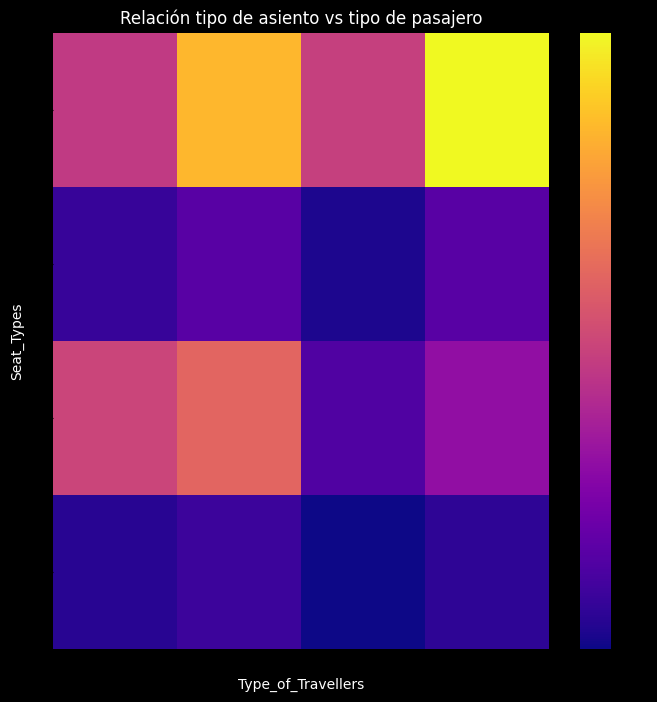

In [ ]:
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Seat_Types'].value_counts()
    for x_label, grp in data.groupby('Type_of_Travellers')
})

# Reordenar las filas del DataFrame
nuevo_orden_filas = ['Economy Class', 'Premium Economy', 'Business Class', 'First Class']  # Cambia esto por el orden deseado
df_2dhist = df_2dhist.reindex(nuevo_orden_filas)

sns.heatmap(df_2dhist, cmap='plasma')
plt.xlabel('Type_of_Travellers', color='white')
_ = plt.ylabel('Seat_Types', color='white')
plt.title('Relación tipo de asiento vs tipo de pasajero', color='white')
plt.gcf().set_facecolor('black')

## Serie de tiempo

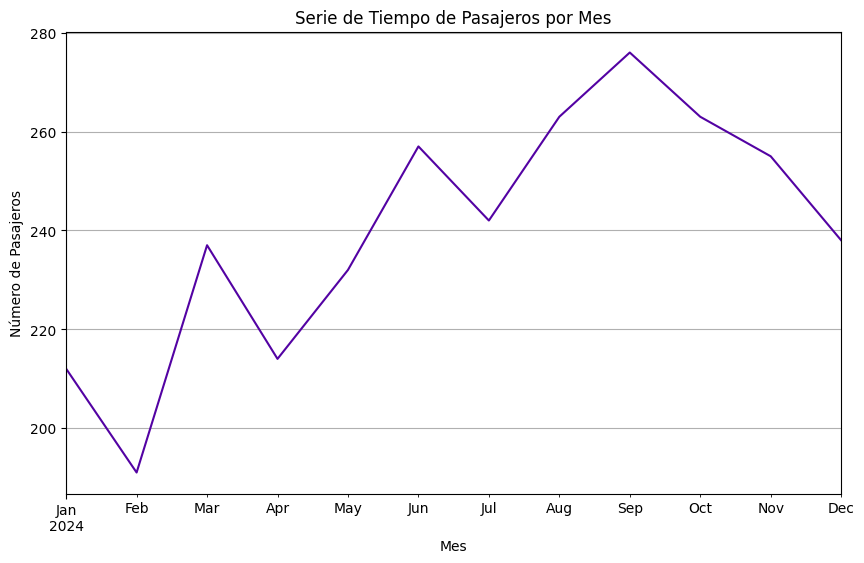

In [ ]:
# Grafica la serie de tiempo por mes
sns.set_palette('plasma')
plt.figure(figsize=(10, 6))
serie_tiempo_por_mes.plot()
plt.title('Serie de Tiempo de Pasajeros por Mes')
plt.xlabel('Mes')
plt.ylabel('Número de Pasajeros')
plt.grid(True)
plt.show()

## Nube de palabras

In [ ]:
# Filtrar las filas donde 'Recommended' es 'yes' y seleccionar solo la columna 'Users Reviews'
reviews_recommended = data.loc[data['Recommended'] == 'yes', 'Users Reviews']
positivo = reviews_recommended.tolist()
# Filtrar las filas donde 'Recommended' es 'no' y seleccionar solo la columna 'Users Reviews'
reviews_no_recommended = data.loc[data['Recommended'] == 'no', 'Users Reviews']
negativo = reviews_no_recommended.tolist()

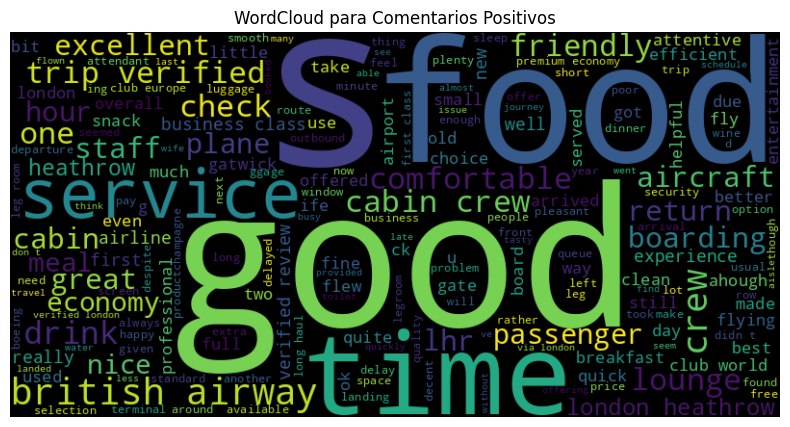

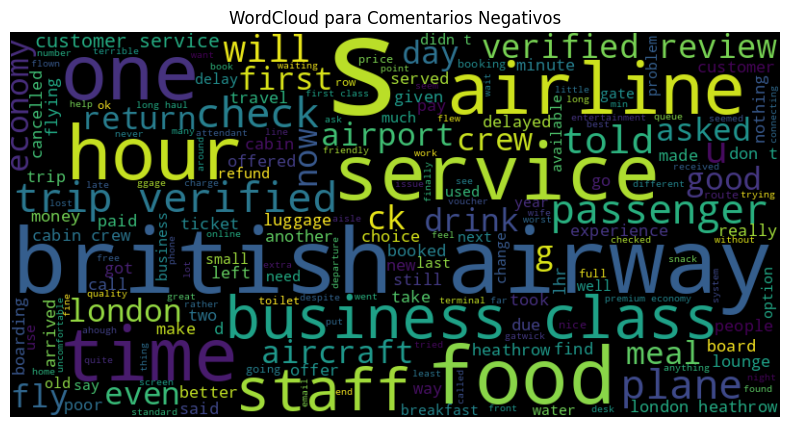

In [ ]:
import re
import string
from wordcloud import WordCloud


# Definir la función clean_text con eliminación de palabras específicas
def clean_text(text):
    text = text.lower()  # Transforma el texto a minúsculas
    text = re.sub('\[.*?¿\]\%', ' ', text)  # Remueve texto entre corchetes y porcentaje
    text = re.sub('[%s¿¡]' % re.escape(string.punctuation), ' ', text)  # Remueve signos de puntuación
    text = re.sub('\w*\d\w*', '', text)  # Remueve palabras que contienen dígitos
    text = re.sub('[‘’“”…«»]', '', text)
    text = re.sub('lt', '', text)
    text = re.sub('\r\n', ' ', text)

    # Eliminar palabras específicas
    words_to_remove = ['flight', 'seat', 'ba']  # Agrega aquí las palabras que deseas eliminar
    for word in words_to_remove:
        text = text.replace(word, '')

    return text

# Convertir las listas de comentarios a texto y aplicar la limpieza
positivo_text = ' '.join([clean_text(comment) for comment in positivo])
negativo_text = ' '.join([clean_text(comment) for comment in negativo])

# Crear una instancia de WordCloud para comentarios positivos
wordcloud_positivo = WordCloud(width=800, height=400, background_color='black').generate(positivo_text)

# Crear una instancia de WordCloud para comentarios negativos
wordcloud_negativo = WordCloud(width=800, height=400, background_color='black').generate(negativo_text)

# Mostrar la nube de palabras para comentarios positivos
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positivo, interpolation='bilinear')
plt.title('WordCloud para Comentarios Positivos')
plt.axis('off')
plt.show()

# Mostrar la nube de palabras para comentarios negativos
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negativo, interpolation='bilinear')
plt.title('WordCloud para Comentarios Negativos')
plt.axis('off')
plt.show()

## Grafico de torta

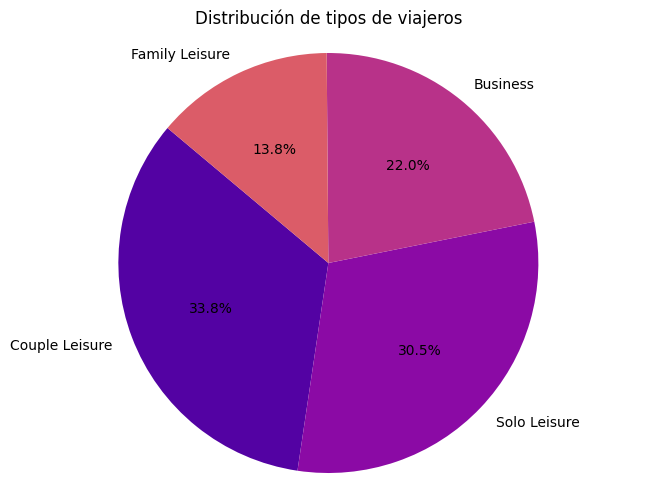

In [ ]:
 # Configurar la paleta de colores
sns.set_palette("plasma")

# Contar la frecuencia de cada tipo de viajero
tipo_viajero_counts = data['Type_of_Travellers'].value_counts()

# Crear el gráfico de torta con Seaborn
plt.figure(figsize=(8, 6))
plt.pie(tipo_viajero_counts, labels=tipo_viajero_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribución de tipos de viajeros')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

#Dashboard

In [ ]:
!pip install dash
!pip install dash-bootstrap-components

In [ ]:
import dash
from dash import dcc, html
import plotly.graph_objs as go
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud

In [142]:
# Definir la aplicación Dash
app = dash.Dash(__name__)

# Estilo de los gráficos
graph_style = {'width': '40%', 'height': '300px'}  # Puedes ajustar el ancho y el alto según tus necesidades
colors = {
    'negro' :'#000000',
    'background': '#111111',
    'text': '#7FDBFF'
}

# Definir los gráficos
# Gráfico de torta
tipo_viajero_counts = data['Type_of_Travellers'].value_counts()
pie_chart = dcc.Graph(
    id='pie-chart',
    figure={
        'data': [go.Pie(
            labels=tipo_viajero_counts.index,
            values=tipo_viajero_counts.values,
            textinfo='label+percent',
            insidetextorientation='radial',
            textposition='inside',
            hole=0.5,
            marker=dict(colors=sns.color_palette("plasma", len(tipo_viajero_counts)))
        )],
        'layout': {
            'title': 'Distribución de tipos de viajeros',
            'plot_bgcolor': '#000000',  # Cambio de color de fondo
            'paper_bgcolor': '#000000',  # Cambio de color de fondo
            'font': {
                'color': colors['text']
            }
        }
    }
)

# Nube de palabras para comentarios positivos
wordcloud_positivo = WordCloud(width=800, height=400, background_color='black').generate(positivo_text)
positive_wordcloud = html.Div([
    html.H2(children='Nube de palabras para Comentarios Positivos', style={'color': colors['text']}),
    html.Img(src=wordcloud_positivo.to_image(), style={'width': '100%', 'height': 'auto'})
])

# Nube de palabras para comentarios negativos
wordcloud_negativo = WordCloud(width=800, height=400, background_color='black').generate(negativo_text)
negative_wordcloud = html.Div([
    html.H2(children='Nube de palabras para Comentarios Negativos', style={'color': colors['text']}),
    html.Img(src=wordcloud_negativo.to_image(), style={'width': '100%', 'height': 'auto'})
])

# Gráfico de serie de tiempo
time_series_graph = dcc.Graph(
    id='time-series-graph',
    figure={
        'data': [go.Scatter(
            x=serie_tiempo_por_mes.index,
            y=serie_tiempo_por_mes.values,
            mode='lines',
            marker=dict(color='#FF851B')
        )],
        'layout': {
            'title': 'Serie de Tiempo de Pasajeros por Mes del 2024',
            'xaxis': {'title': 'Mes'},
            'yaxis': {'title': 'Número de Pasajeros'},
            'plot_bgcolor': '#000000',  # Cambio de color de fondo
            'paper_bgcolor': '#000000',  # Cambio de color de fondo
            'font': {
                'color': colors['text']
            }
        }
    }
)

# Mapa de calor
heatmap = dcc.Graph(
    id='heatmap',
    figure={
        'data': [go.Heatmap(
            z=df_2dhist.values,
            y=df_2dhist.index,
            x=df_2dhist.columns,
            colorscale='Plasma'
        )],
        'layout': {
            'title': 'Relación tipo de asiento vs tipo de pasajero',
            'yaxis': {'title': 'Seat_Types', 'tickangle': -20},
            'xaxis': {'title': 'Type_of_Travellers', 'tickangle': -30},
            'plot_bgcolor': '#000000',  # Cambio de color de fondo
            'paper_bgcolor': '#000000',  # Cambio de color de fondo
            'font': {
                'color': colors['text']
            },
            'margin': {'l': 150,'t': 50, 'b': 100}  # Ajuste de los márgenes superior e inferior
        }
    }
)
# Mapa coroplético
choropleth_map = dcc.Graph(
    id='choropleth-map',
    figure=fig
)


# Crear el layout del dashboard
# Agregar los gráficos al layout con la disposición deseada utilizando Flexbox
app.layout = html.Div(style={'backgroundColor': colors['negro'], 'padding': '20px'}, children=[
    html.H1(
        children='Airlines: Análisis de Datos de Viajes',
        style={
            'textAlign': 'center',
            'color': colors['text'],
            'marginBottom': '20px'  # Añade margen inferior al título
        }
    ),
    html.Div(
        children='El conjunto de datos Airlines proporciona una amplia colección de comentarios de pasajeros sobre su experiencia de vuelo,  ofreciendo información sobre la satisfacción del cliente y la calidad del servicio.',
        style={
            'textAlign': 'center',
            'color': colors['text'],
            'marginBottom': '20px'  # Añade margen inferior al texto
        }
    ),
    # Primera fila
    # Primera fila
    html.Div([
        html.Div([choropleth_map], style={'margin': 'auto', 'display': 'flex', 'justifyContent': 'center'})
    ], style={'textAlign': 'center'}),
    # Segunda fila
    html.Div([
        html.Div([pie_chart], style={'flex': '45%', 'marginRight': '10px'}),
        html.Div([time_series_graph], style={'flex': '55%'})
    ], style={'display': 'flex', 'justifyContent': 'space-around', 'marginBottom': '20px'}),

    # Tercera fila
    html.Div([
        html.Div([negative_wordcloud],style={'flex': '30%', 'marginRight': '10px'}),  # Agrega margen derecha
        html.Div([positive_wordcloud],style={'flex': '30%', 'marginLeft': '10px'}),  # Agrega margen izquierda
        html.Div([heatmap], style={'flex': '40%'})
    ], style={'display': 'flex', 'justifyContent': 'space-around', 'marginBottom': '20px'}),
])


if __name__ == '__main__':
    #app.run_server(debug=True)
    app.run_server(debug=True, use_reloader=False)


<IPython.core.display.Javascript object>